# 0. Install Dependencies and Bring in Data

In [1]:
!pip install tensorflow  pandas matplotlib scikit-learn

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv')

'jigsaw-toxic-comment-classification-challenge\\train.csv\\train.csv'

In [4]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [6]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.4.0
aiofiles                     23.2.1
altair                       5.3.0
annotated-types              0.7.0
anyio                        3.6.2
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        22.2.0
backcall                     0.2.0
beautifulsoup4               4.12.0
bleach                       6.0.0
cachetools                   5.3.0
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           3.1.0
click                        8.1.3
colorama                     0.4.6
comm                         0.1.3
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.6
decorator                    5.1.1
defusedxml                   0.7.1
dns

In [9]:
from tensorflow.keras.layers import TextVectorization

In [10]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [11]:
MAX_FEATURES = 200000 # number of words in the vocab

In [12]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [13]:
vectorizer.adapt(X.values)

In [14]:
vectorized_text = vectorizer(X.values)

In [16]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [17]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [19]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [20]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [22]:
history = model.fit(train, epochs=2, validation_data=val)

Epoch 1/2
6981/6981 [==============================] - 10874s 2s/step - loss: 0.0624 - val_loss: 0.0485
Epoch 2/2
6981/6981 [==============================] - 10389s 1s/step - loss: 0.0457 - val_loss: 0.0400


In [23]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

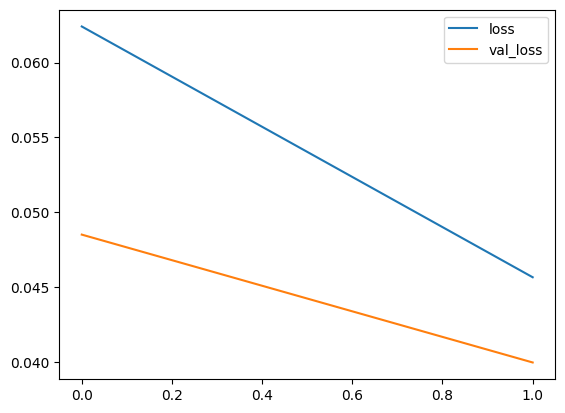

In [24]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [25]:
batch=test.as_numpy_iterator().next()

In [26]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [27]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [28]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 4s 4s/step


array([[0.9976465 , 0.30736405, 0.95945233, 0.05342341, 0.85928845,
        0.13141362]], dtype=float32)

In [29]:
batch=test.as_numpy_iterator().next()

In [30]:
batch_X,batch_y=test.as_numpy_iterator().next()

In [31]:
(model.predict(batch_X)>0.5).astype(int)

1/1 [==============================] - 1s 770ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0]])

In [32]:
res=model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 191ms/step


In [33]:
res.shape

(1, 6)

# 4. Evaluate Model

In [34]:
!pip install gradio jinja2


In [35]:
import gradio as gr

In [36]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [37]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [38]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 266ms/step


In [39]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.841017484664917, Recall:0.7427688837051392, Accuracy:0.5025075078010559


# 5. Test and Gradio

In [40]:
!pip install gradio jinja2

In [41]:
import gradio as gr

In [42]:
model.save('toxicity.h5')

In [43]:
model = tf.keras.models.load_model('toxicity.h5')

In [44]:
input_str = vectorizer('hey i freaken hate you!')

In [45]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 2s 2s/step


In [46]:
res

array([[0.68111   , 0.00513927, 0.15875158, 0.02355218, 0.23617046,
        0.0348025 ]], dtype=float32)

In [47]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [50]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.components.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

IMPORTANT: You are using gradio version 3.50.2, however version 4.29.0 is available, please upgrade.
--------


In [51]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://332c857a7a635b2e16.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 169ms/step
